<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Labeling/Cleaning_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring, Cleaning and Labeling the data
### Stacey Beck and Ian Byrne

<br><br/>

##### **AI Crowd Labeling Method**

We received inspiration from the AI Crowd's Alzheimer's Clock Challenge and reached out to their data team inquiring about labeling the clock images for that challenge. Ankit < insert last name > explained that they use the values in the variable 'hc1disescn9' to help label the images. The variable 'hc1disescn9' contains values that indicate whether someone has dementia/Alzheimer's or not. A response of '1 YES' indicates that they have a confirmed diagnosis of Alzheimer's or Dementia and '2 NO' indicates no diagnosis has been given. A value of '7' indicates that a response of '1 YES' has already been recorded in a previous round. AI Crowd labeled each image as either:
  - 0 - Pre-Alzheimers
  - 1 - Post-Alzheimers 
  - 2 - Normal

If a subject reports '1 YES' in the variable 'hc1disescn9' in a later round, all the previous rounds receive the label '0 - Pre-Alzheimers'. All 'hc1disescn9' reports of '1 YES' and '7' receive the label '1 - Post-Alzheimers' for the current and subsequent rounds.  All else receive the label '2 - Normal.' 

We provide code to produce labels using this algorithm. 

 
<br><br/>
 
##### **NHATs Study Criteria used to help make Labels**

In addition, we also feel that this way of labeling can lead to false negatives in terms of whether someone might have dementia/Alzheimer's disease. There may be participants whose diagnosis has gone undetected by medical professionals and who are able to complete the NHATs survey, thus leading to a label of '2 - Normal' for their drawings. 

In order to provide a potentially more robust set of label parameters, we will also implement a label strategy that mimicks the NHAT study found in this report. https://www.nhats.org/sites/default/files/inline-files/DementiaTechnicalPaperJuly_2_4_2013_10_23_15.pdf (page 2)


We will use these specific labels to identify if someone has:
- 0 - 'Possible Dementia'
- 1 - 'Probable Dementia' (Likely Dementia)
- 2 - 'No Dementia' 

**Variables used to help classify '0' for "Possible Dementia":**
- One cognitive test score with cut off <= 1.5 SD below the mean. 

**Variables used to help classify '1' for 'Probable Dementia' include:**
-  'hc1disescn9' for diagnosis ('1 YES', '2 NO', '7') and if this is not provided we will look at:
  - 'cp1dad8dem' which provides a diagnosing like score through the use of a proxy. 
- Two cognitive test scores with cut offs <= 1.5 SD below the mean. 


**All else will be labeled as '2' for 'No Dementia."**

<br><br/>
The cognitive tests are based in three domains:
- ***Orientation*** 
    - President and VP First and Last names: **'cg1presidna1', 'cg1presidna3', 'cg1vpname1', 'cg1vpname3'**
    - Date, Month, Year, Day of the Week: **'cg1todaydat1' (Month), 'cg1todaydat2' (Day), 'cg1todaydat3' (Year), 'cg1todaydat4' (Day of the Week)**
    - Each correct answer gets a point; Total points out of 8.
    - Score cut point for <= 1.5 SD below the mean is <= 3 across all variables
- ***Memory*** 
    - Delayed Word Recall: **'cg1dwrdimmrc' (total Score)**
    - Immediate Word Recall: **'cg1dwrddlyrc' (total Score)** 
    - Total points out of 20
    - Score cut off is <= 3 across all variables
- ***Executive Functioning*** 
    - Clock Drawing Battery: **'cg1dclkdraw'**
    - Total points out of 5
    - Score cut off is <= 1 


***Each variable is used for all 9 years of this study and change only by the number value located within the variable name.***


In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 449 (delta 252), reused 170 (delta 71), pack-reused 0
Receiving objects: 100% (449/449), 3.24 MiB | 5.70 MiB/s, done.
Resolving deltas: 100% (252/252), done.
/content/MADSmilestone2
Data			 Images.ipynb  Labeling  README.md
ian_testingground.ipynb  Images.py     Loading	 Supervised_CNN.ipynb


In [ ]:
#!rm -rf /content/MADSmilestone2

In [2]:
import pandas as pd
import numpy as np
import Labeling.clean_rounds as cr
import Labeling.label_data as ld
import matplotlib.pyplot as plt

### AI Crowd Labeling Strategy

---



In [ ]:
# Load Rounds data
rounds = pd.read_csv('Data/round_data.csv')
rounds.head()

,spid,cg1dclkdraw,hc1disescn9,round
0,10000003.0,3 Mildly distorted depiction of a clock,2 NO,1
1,10000004.0,3 Mildly distorted depiction of a clock,2 NO,1
2,10000005.0,3 Mildly distorted depiction of a clock,2 NO,1
3,10000006.0,4 Reasonably accurate depiction of a clock,2 NO,1
4,10000007.0,-2 Proxy says cannot ask SP,2 NO,1


###Check values for columns of interest
- we used the user guide to determine which columns are required


In [ ]:
print("Column values for clock scores: \n", rounds['cg1dclkdraw'].unique())
print("\nHealth score values: \n", rounds['hc1disescn9'].unique())
print("\nVariable types: \n", rounds.dtypes)
rounds[rounds['cg1dclkdraw'] == '-1 Inapplicable'].head()

Column values for clock scores: 
 ['3 Mildly distorted depiction of a clock'
 '4 Reasonably accurate depiction of a clock'
 '-2 Proxy says cannot ask SP'
 '2 Moderately distorted depection of a clock' '-1 Inapplicable'
 '-7 SP refused to draw clock'
 '5 Accurate depiction of a clock (circular or square)'
 '1 Severely distorted depiction of a clock'
 '-4 SP did not attempt to draw clock' '0 Not recognizable as a clock'
 '-3 Proxy says can ask SP but SP unable to answer' '-9 Missing'
 '2 Moderately distorted depiction of a clock']

Health score values: 
 [' 2 NO' '-1 Inapplicable' ' 1 YES' '-9 Missing' '-8 DK' '2 NO'
 '7 PREVIOUSLY REPORTED' '1 YES' '-7 RF']

Variable types: 
 spid           float64
cg1dclkdraw     object
hc1disescn9     object
round            int64
dtype: object


,spid,cg1dclkdraw,hc1disescn9,round
6,10000009.0,-1 Inapplicable,-1 Inapplicable,1
8,10000013.0,-1 Inapplicable,-1 Inapplicable,1
10,10000015.0,-1 Inapplicable,-1 Inapplicable,1
33,10000046.0,-1 Inapplicable,-9 Missing,1
47,10000067.0,-1 Inapplicable,-9 Missing,1


In [ ]:
# Load the cleaned dataframe
cleaned_rounds = cr.clean_data(rounds)
cleaned_rounds.head()

,spid,cg1dclkdraw,hc1disescn9,round
0,10000003,3 Mildly distorted depiction of a clock,2.0,1
1,10000004,3 Mildly distorted depiction of a clock,2.0,1
2,10000005,3 Mildly distorted depiction of a clock,2.0,1
3,10000006,4 Reasonably accurate depiction of a clock,2.0,1
5,10000008,2 Moderately distorted depection of a clock,2.0,1


In [ ]:
#Check that we only have healthscores of 1, 2, 7 and subjects that have drawn clocks
print("health score check: \n",cleaned_rounds.cg1dclkdraw.unique())
print("\n clock scores check: \n",cleaned_rounds['hc1disescn9'].unique())

health score check: 
 ['3 Mildly distorted depiction of a clock'
 '4 Reasonably accurate depiction of a clock'
 '2 Moderately distorted depection of a clock'
 '5 Accurate depiction of a clock (circular or square)'
 '1 Severely distorted depiction of a clock'
 '0 Not recognizable as a clock'
 '2 Moderately distorted depiction of a clock']

 clock scores check: 
 [2. 1. 7.]


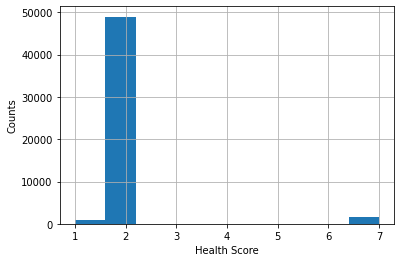

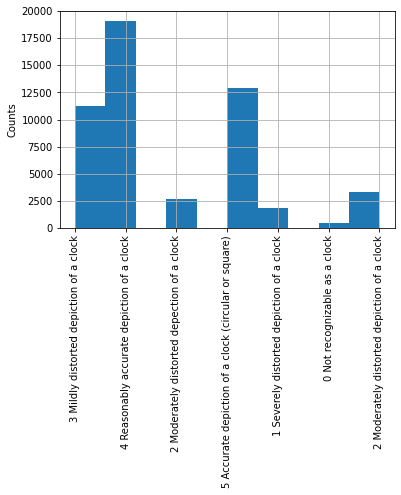

In [ ]:
# Check balance of dataset
a = cleaned_rounds.hc1disescn9.hist() 
plt.xlabel("Health Score")
plt.ylabel("Counts")
plt.show(a) 


b = cleaned_rounds.cg1dclkdraw.hist()
b.tick_params(axis='x', labelrotation = 90)
plt.ylabel("Counts")
plt.show(b)

###Create Labels for the rounds data

In [ ]:
labeled_data = ld.create_labels(cleaned_rounds)
labeled_data.head()

,spid,cg1dclkdraw,hc1disescn9,round,label
0,10000003,3 Mildly distorted depiction of a clock,2.0,1,0
1,10000004,3 Mildly distorted depiction of a clock,2.0,1,2
2,10000005,3 Mildly distorted depiction of a clock,2.0,1,2
3,10000006,4 Reasonably accurate depiction of a clock,2.0,1,2
5,10000008,2 Moderately distorted depection of a clock,2.0,1,2


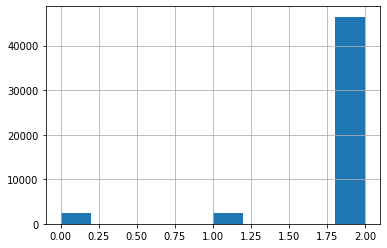

In [ ]:
# Look at distribution of labels
labeled_data.label.hist() 

In [ ]:
labeled_data['label'].value_counts()

2    46490
1     2533
0     2469
Name: label, dtype: int64

### NHATs Strategy for Labeling Data

---



In [3]:
round_hat_data = pd.read_csv('Data/hats_round_data.csv')
round_hat_data.head()

,spid,cg1dclkdraw,hc1disescn9,cg1presidna1,cg1presidna3,cg1vpname1,cg1vpname3,cg1todaydat1,cg1todaydat2,cg1todaydat3,cg1todaydat4,cg1dwrdimmrc,cg1dwrddlyrc,round,cp1dad8dem
0,10000003.0,3 Mildly distorted depiction of a clock,2 NO,1 YES,1 YES,1 YES,1 YES,1 YES,1 YES,1 YES,1 YES,6.0,3.0,1,NaN
1,10000004.0,3 Mildly distorted depiction of a clock,2 NO,1 YES,1 YES,2 NO,2 NO,1 YES,1 YES,1 YES,1 YES,4.0,3.0,1,NaN
2,10000005.0,3 Mildly distorted depiction of a clock,2 NO,1 YES,1 YES,1 YES,1 YES,1 YES,1 YES,1 YES,1 YES,7.0,4.0,1,NaN
3,10000006.0,4 Reasonably accurate depiction of a clock,2 NO,1 YES,1 YES,1 YES,2 NO,1 YES,1 YES,1 YES,1 YES,4.0,3.0,1,NaN
4,10000007.0,-2 Proxy says cannot ask SP,2 NO,-1 Inapplicable,-1 Inapplicable,-1 Inapplicable,-1 Inapplicable,-1 Inapplicable,-1 Inapplicable,-1 Inapplicable,-1 Inapplicable,-2 Proxy says cannot ask SP,-2 Proxy says cannot ask SP,1,NaN


In [4]:
# Check all values for each variable prior to cleaning; variables are picked from
# NHATs User Guide
columns_to_keep = ['cg1presidna1','cg1presidna3','cg1vpname1','cg1vpname3',
           'cg1todaydat1','cg1todaydat2','cg1todaydat3', 'cg1todaydat4',
           'cg1dclkdraw','hc1disescn9', 'cp1dad8dem', 'cg1dwrdimmrc',
           'cg1dwrddlyrc']

d = round_hat_data[columns_to_keep]

for col in d.columns:
  print("\n{}: \n".format(col), d[col].unique())


cg1presidna1: 
 [' 1 YES' '-1 Inapplicable' ' 2 NO' '-9 Missing' '-7 RF' ' 1 Yes' ' 2 No']

cg1presidna3: 
 [' 1 YES' '-1 Inapplicable' ' 2 NO' '-9 Missing' '-7 RF' ' 1 Yes' ' 2 No']

cg1vpname1: 
 [' 1 YES' ' 2 NO' '-1 Inapplicable' '-9 Missing' '-7 RF' ' 1 Yes' ' 2 No']

cg1vpname3: 
 [' 1 YES' ' 2 NO' '-1 Inapplicable' '-9 Missing' '-7 RF' ' 1 Yes' ' 2 No']

cg1todaydat1: 
 [' 1 YES' '-1 Inapplicable' '-9 Missing' " 2 NO/DON'T KNOW" '-7 RF'
 '1 YES' "2 NO/DON'T KNOW"]

cg1todaydat2: 
 [' 1 YES' '-1 Inapplicable' " 2 NO/DON'T KNOW" '-9 Missing' '-7 RF'
 '1 YES' "2 NO/DON'T KNOW"]

cg1todaydat3: 
 [' 1 YES' '-1 Inapplicable' '-9 Missing' " 2 NO/DON'T KNOW" '-7 RF'
 '1 YES' "2 NO/DON'T KNOW"]

cg1todaydat4: 
 [' 1 YES' '-1 Inapplicable' '-9 Missing' " 2 NO/DON'T KNOW" '-7 RF'
 '1 YES' "2 NO/DON'T KNOW"]

cg1dclkdraw: 
 ['3 Mildly distorted depiction of a clock'
 '4 Reasonably accurate depiction of a clock'
 '-2 Proxy says cannot ask SP'
 '2 Moderately distorted depection of a clock' '

In [5]:
# Run cleaning script resave dataframe
round_hat_clean = cr.clean_hats_rounds(round_hat_data)
round_hat_clean.head()

,spid,cg1dclkdraw,hc1disescn9,cg1presidna1,cg1presidna3,cg1vpname1,cg1vpname3,cg1todaydat1,cg1todaydat2,cg1todaydat3,cg1todaydat4,cg1dwrdimmrc,cg1dwrddlyrc,round,cp1dad8dem
0,10000003,3.0,2,1,1,1,1,1.0,1.0,1.0,1.0,6.0,3.0,1,10
1,10000004,3.0,2,1,1,0,0,1.0,1.0,1.0,1.0,4.0,3.0,1,10
2,10000005,3.0,2,1,1,1,1,1.0,1.0,1.0,1.0,7.0,4.0,1,10
3,10000006,4.0,2,1,1,1,0,1.0,1.0,1.0,1.0,4.0,3.0,1,10
5,10000008,2.0,2,1,1,1,1,1.0,1.0,1.0,1.0,7.0,7.0,1,10


In [6]:
# Check all column values again
columns_to_keep = ['cg1presidna1','cg1presidna3','cg1vpname1','cg1vpname3',
           'cg1todaydat1','cg1todaydat2','cg1todaydat3', 'cg1todaydat4',
           'cg1dclkdraw','hc1disescn9', 'cp1dad8dem', 'cg1dwrdimmrc',
           'cg1dwrddlyrc']

d = round_hat_clean[columns_to_keep]

for col in d.columns:
  print("\n{}: \n".format(col), d[col].unique())


cg1presidna1: 
 [1 0]

cg1presidna3: 
 [1 0]

cg1vpname1: 
 [1 0]

cg1vpname3: 
 [1 0]

cg1todaydat1: 
 [ 1.  0. nan]

cg1todaydat2: 
 [ 1.  0. nan]

cg1todaydat3: 
 [ 1.  0. nan]

cg1todaydat4: 
 [ 1.  0. nan]

cg1dclkdraw: 
 [3. 4. 2. 5. 1. 0.]

hc1disescn9: 
 [ 2  1  0  7 10]

cp1dad8dem: 
 [10  0  1]

cg1dwrdimmrc: 
 ['6.0' '4.0' '7.0' '5.0' '3.0' '2.0' '0.0' '8.0' 0 '1.0' '9.0' '10.0' nan]

cg1dwrddlyrc: 
 ['3.0' '4.0' '7.0' '5.0' '2.0' '6.0' '0.0' '1.0' 0 '8.0' '9.0' '10.0' nan]


In [7]:
# Drop the rest of the NaN values since we do not have data for these subjects and
# cannot conclude their scores
round_hat_clean.dropna(inplace=True)

# Check dtypes
round_hat_clean.dtypes

spid             string
cg1dclkdraw     float64
hc1disescn9       int64
cg1presidna1      int64
cg1presidna3      int64
cg1vpname1        int64
cg1vpname3        int64
cg1todaydat1    float64
cg1todaydat2    float64
cg1todaydat3    float64
cg1todaydat4    float64
cg1dwrdimmrc     object
cg1dwrddlyrc     object
round             int64
cp1dad8dem        int64
dtype: object

In [8]:
# Change variable value types from Categorical to Int64 for later calculations
col_to_change = ['cg1presidna1','cg1presidna3','cg1vpname1','cg1vpname3',
           'cg1todaydat1','cg1todaydat2','cg1todaydat3', 'cg1todaydat4',
           'cg1dclkdraw','hc1disescn9', 'cp1dad8dem', 'cg1dwrdimmrc',
           'cg1dwrddlyrc']
round_hat_clean[col_to_change] = round_hat_clean[col_to_change].apply(pd.to_numeric)

In [9]:
# Create orientation and memory scores
round_hat_clean['orientation_score'] = round_hat_clean['cg1presidna1'] + round_hat_clean['cg1presidna3'] \
+ round_hat_clean['cg1vpname1'] + round_hat_clean['cg1vpname3'] + round_hat_clean['cg1todaydat1']\
+ round_hat_clean['cg1todaydat2'] + round_hat_clean['cg1todaydat3'] + round_hat_clean['cg1todaydat4']

round_hat_clean['memory_score'] = round_hat_clean['cg1dwrdimmrc'] + round_hat_clean['cg1dwrddlyrc']

In [13]:
round_hat_clean['cg1dclkdraw'] = round_hat_clean.cg1dclkdraw.astype('int64')

In [14]:
round_hat_clean.dtypes

spid                  string
cg1dclkdraw            int64
hc1disescn9            int64
cg1presidna1           int64
cg1presidna3           int64
cg1vpname1             int64
cg1vpname3             int64
cg1todaydat1         float64
cg1todaydat2         float64
cg1todaydat3         float64
cg1todaydat4         float64
cg1dwrdimmrc         float64
cg1dwrddlyrc         float64
round                  int64
cp1dad8dem             int64
orientation_score    float64
memory_score         float64
dtype: object

In [ ]:
# Save a copy of hats_cleaned_data as csv
#round_hat_clean.to_csv("Data/cleaned_nhat_data.csv", index = False)

In [16]:
# Call script that creates the labels for each subject
round_hat_label = ld.create_hats_labels(round_hat_clean)[['round', 'spid', 'label']]
round_hat_label.sample(10)

,round,spid,label
4869,1,10007353,2
13174,2,10008646,2
33471,5,20005903,2
20222,3,10010346,0
13234,2,10008747,2
4571,1,10006906,2
3442,1,10005268,2
31712,5,20002858,2
13152,2,10008603,1
51606,8,20002556,2


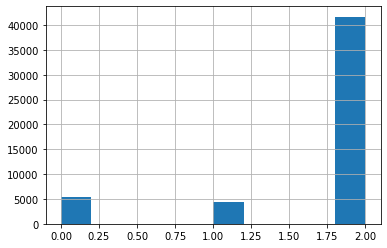

In [17]:
round_hat_label.label.hist() 

In [18]:
round_hat_label['label'].value_counts()

2    41656
0     5312
1     4393
Name: label, dtype: int64

## Testing AI strategy of labeling on NHATs
Logic: If an SPID for all rounds returns different labels, we want to make sure these labels consistently illustrate the cognitive trend. 


If and SPID's labels contain 2's, 0's and 1's, the most logical decision would be to assign all rounds before the appearance of a 1 as a 0. (Possible dementia preceeds a diagnosis classification of dementia). 


If the subject contains only 2's and 0 labels, all rounds prior to the first appearance of a label of 0 should keep the label of 2. (No dementia preceeds possible onset of dementia)

We should then see different label combinations of either (2..., 0...), (2...), (0...), (0..., 1...), or (1...)



In [19]:
final_df = round_hat_label.copy()

In [20]:
# Pre-final labeling test 
ids_test = ['10000006','10000024','20006986', '10000041','10000131', '10000175', '10000047', '20007062' ]
for nums in ids_test:
  print(final_df[final_df['spid'] == nums])

   round      spid  label
3      1  10000006      2
       round      spid  label
17         1  10000024      2
8258       2  10000024      0
16510      3  10000024      0
22100      4  10000024      1
       round      spid  label
34111      5  20006986      1
41398      6  20006986      2
47726      7  20006986      2
53278      8  20006986      0
58262      9  20006986      1
62655     10  20006986      0
       round      spid  label
28         1  10000041      0
8268       2  10000041      2
16744      3  10000041      2
22301      4  10000041      2
25869      5  10000041      0
34203      6  10000041      2
41477      7  10000041      0
47788      8  10000041      0
53333      9  10000041      2
58309     10  10000041      2
       round      spid  label
8321       2  10000131      2
18110      3  10000131      2
23412      4  10000131      2
25902      5  10000131      0
34233      6  10000131      2
41504      7  10000131      2
       round      spid  label
120        1  1000

In [21]:
# final label strategy
final_label_df = ld.custom_label(final_df)

In [22]:
# Post-final labeling test 
ids_test = ['10000006','10000024','20006986', '10000041','10000131', '10000175', '10000047', '20007062' ]
for nums in ids_test:
  print(final_label_df[final_label_df['spid'] == nums])

   round      spid  label
3      1  10000006      2
       round      spid  label
17         1  10000024      0
8258       2  10000024      0
16510      3  10000024      0
22100      4  10000024      1
       round      spid  label
34111      5  20006986      1
41398      6  20006986      1
47726      7  20006986      1
53278      8  20006986      1
58262      9  20006986      1
62655     10  20006986      1
       round      spid  label
28         1  10000041      0
8268       2  10000041      0
16744      3  10000041      0
22301      4  10000041      0
25869      5  10000041      0
34203      6  10000041      0
41477      7  10000041      0
47788      8  10000041      0
53333      9  10000041      0
58309     10  10000041      0
       round      spid  label
8321       2  10000131      2
18110      3  10000131      2
23412      4  10000131      2
25902      5  10000131      0
34233      6  10000131      0
41504      7  10000131      0
       round      spid  label
120        1  1000

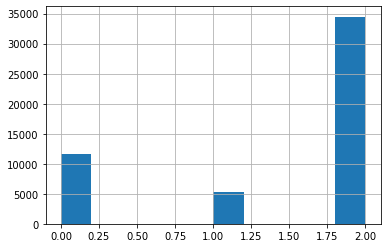

In [23]:
final_label_df.label.hist()

In [24]:
final_label_df['label'].value_counts()

2    34483
0    11658
1     5220
Name: label, dtype: int64

## Label strategy keeping only 4 combinations
(2...), (0...), (0...,1...), (1...)


In [ ]:
# rounds greater than the round where 0 appears, get a 0, except if the value is a 1 (stays a 1)
four_combo = ld.four_combo_label(final_df)

In [ ]:
# Post-final labeling test 
ids_test = ['10000006','10000024','20006986', '10000041','10000131', '10000175', '10000047', '20007062' ]
for nums in ids_test:
  print(four_combo[four_combo['spid'] == nums])

   round      spid  label
3      1  10000006      2
       round      spid  label
17         1  10000024      0
8258       2  10000024      0
16510      3  10000024      0
22100      4  10000024      1
       round      spid  label
34111      5  20006986      1
41398      6  20006986      1
47726      7  20006986      1
53278      8  20006986      1
58262      9  20006986      1
62655     10  20006986      1
       round      spid  label
28         1  10000041      0
8268       2  10000041      0
16744      3  10000041      0
22301      4  10000041      0
25869      5  10000041      0
34203      6  10000041      0
41477      7  10000041      0
47788      8  10000041      0
53333      9  10000041      0
58309     10  10000041      0
       round      spid  label
8321       2  10000131      0
18110      3  10000131      0
23412      4  10000131      0
25902      5  10000131      0
34233      6  10000131      0
41504      7  10000131      0
       round      spid  label
120        1  1000

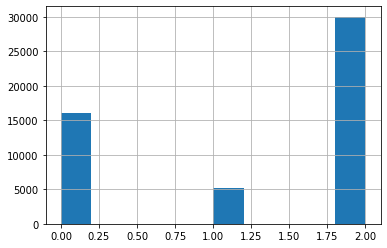

In [ ]:
four_combo.label.hist()

In [ ]:
four_combo['label'].value_counts()

2    30019
0    16122
1     5220
Name: label, dtype: int64

## Get Individual participant IDs and labels per round
- useful for pulling in exact images per round
- create text file to store dictionary

- create one dictionary file for AI Crowd method of labeling
- create one dictionary file for NHAT Study Dementia Labeling method
- create final custom label dictionary

In [ ]:
#print(labeled_data['round'].value_counts(), len(labeled_data)) # AI CROWD
print(round_hat_label['round'].value_counts(), len(round_hat_data)) # NHATS
#print(final_label_df['round'].value_counts(), len(final_label_df)) # COMBO AI and NHATS
#print(round_hat_clean['cg1dclkdraw'].value_counts())

5     7067
1     6918
6     5997
2     5504
7     5256
8     4658
3     4459
9     4186
4     3671
10    3645
Name: round, dtype: int64 51361


In [ ]:
# get round, id, label for AI crowd method
ids_ai = ld.get_ids(labeled_data, 'label')

# Writing dictionary to text file for AI Crowd method of labeling
try:
    id_file = open('roundIdLabelDict.txt', 'wt')
    id_file.write(str(ids_ai))
    id_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
# get round, id, label for NHAT method
ids_hats = ld.get_ids(round_hat_label, 'label')

# Writing dictionary to text file for NHATs method of labeling
try:
    id_file = open('hatRoundIdLabelDict.txt', 'wt')
    id_file.write(str(ids_hats))
    id_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
# get round, id, label for nhat, AI methods and custom method combined
id_custom = ld.get_ids(final_label_df, 'label')

# Writing dictionary to text file for custom labeling
try:
    id_file = open('customLabelDict.txt', 'wt')
    id_file.write(str(id_custom))
    id_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
# get round, id, label for custom four combo method 
id_four_combo = ld.get_ids(four_combo, 'label')

# Writing dictionary to text file for custom four combo labeling
try:
    id_file = open('fourComboCustomLabelDict.txt', 'wt')
    id_file.write(str(id_four_combo))
    id_file.close()
  
except:
    print("Unable to write to file")

In [15]:
# get round, id, clockdrawing (cg1dclkdraw) score (as labels)
clock_score = ld.get_ids(round_hat_clean, 'cg1dclkdraw')

# Writing dictionary to text file for custom four combo labeling
try:
    id_file = open('Data/clockScoreDict.txt', 'wt')
    id_file.write(str(clock_score))
    id_file.close()
  
except:
    print("Unable to write to file")

# Split final df data and check balance
splitting on 80, 10, 10

In [68]:
train_df = final_label_df[:41089]
temp = final_label_df[41089:]
val_df = temp[:5136]
test_df = temp[5136:]

In [69]:
print(len(train_df))
print(len(val_df))
print(len(test_df))
print(len(train_df)+len(val_df)+len(test_df))


41089
5136
5136
51361


Train data: 



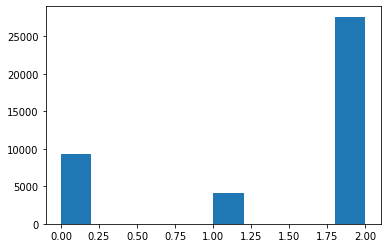

Val data: 



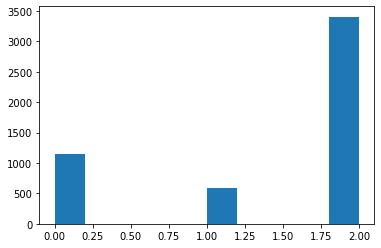

Test data: 



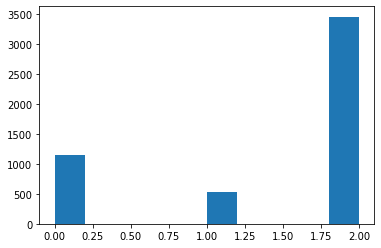

In [70]:
print("Train data: \n")
plt.hist(train_df.label)
plt.show()
print("Val data: \n")
plt.hist(val_df.label)
plt.show()
print("Test data: \n")
plt.hist(test_df.label)
plt.show()

## Undersample the imbalanced in Training set only

In [105]:
# import the Random Under Sampler object.
from imblearn.under_sampling import RandomUnderSampler

# create the object.
under_sampler = RandomUnderSampler(sampling_strategy = 'majority', random_state = 42)

# fit the object to the training data.
x_train_under, y_train_under = under_sampler.fit_sample(train_df.spid, train_df.label)

ValueError: ignored

In [106]:
train_df.spid

0        10000003
1        10000004
2        10000005
3        10000006
5        10000008
           ...   
50455    10011682
50456    10011689
50457    10011693
50459    10011707
50460    10011708
Name: spid, Length: 41089, dtype: string

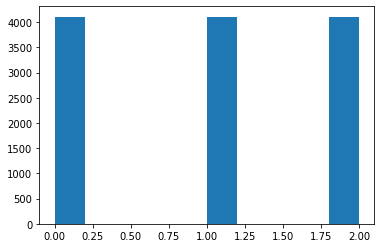

In [92]:
plt.hist(bal_train.label)
plt.show()


In [95]:
len(bal_train)
2536/12321

0.2058274490706923

In [ ]:
# Create Training dictionary
train_dict = ld.get_ids(train_df, 'label')

# Writing dictionary to text file for training
try:
    id_file = open('train_dict.txt', 'wt')
    id_file.write(str(train_dict))
    id_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
# Create validation dictionary
val_dict = ld.get_ids(val_df, 'label')

# Writing dictionary to text file for validating
try:
    id_file = open('val_dict.txt', 'wt')
    id_file.write(str(val_dict))
    id_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
# Create test dictionary
test_dict = ld.get_ids(test_df, 'label')

# Writing dictionary to text file for testing
try:
    id_file = open('test_dict.txt', 'wt')
    id_file.write(str(test_dict))
    id_file.close()
  
except:
    print("Unable to write to file")